# Importing packages

In [1]:
import torch
import numpy as np
import lightning as L

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../transforms/')
sys.path.append('../TFC_Configs/')
sys.path.append('../models/')
sys.path.append('../data_modules/')
sys.path.append('../best_results/')

from config_files.TFC_Configs import *
from transforms.tfc_augmentations import *
from transforms.tfc_utils import set_seed, plot_backbone_metrics, plot_model_metrics
from models.tfc import *
from data_modules.uci_4_tfc import *
from best_results.HAR.tfc_train import load_pretrained_backbone, build_downstream_datamodule, build_lightning_trainer, downstream_save_weights, build_downstream_model

In [4]:
set_seed(42)

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'Times New Roman',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# 1.0 Creating the Downstream Task Training Loop

In [6]:
log_dir = "lightning_logs"
SSL_technique_prefix = 'TF_C'
experiment_name = SSL_technique_prefix

In [7]:
pretrain_backbone_output_filename = f"./{log_dir}/{SSL_technique_prefix}/Pretext/pth_files/TF_C_pretrained_backbone_weights.pth"

batch_size = 2 # We have so few data that we have decided to only use a batch size of 2
global_config_file = GlobalConfigFile(batch_size=batch_size) 

In [8]:
# Load the pretrained backbone
backbone = load_pretrained_backbone(pretrain_backbone_output_filename,global_config_file)

Creating the HAR data module for the downstream task

In [9]:
downstream_datamodule = build_downstream_datamodule(batch_size=batch_size,
                                                    global_config_file=global_config_file,
                                                    root_data_dir="../data/har")

Creating the downstream model with the initialized pretext encoder. Instead of having a linear readout, I am using the same projector head model for the prediction head, which is a neural network with two hidden layers, which is what the original authors of the TF-C paper used. You can, however use your own custom class in the parameter 'prediction_head'

# 2.0 The Effect of Freezing the Backbone

You can check if the model is frozen or not based on the untrainable parameters

In [10]:
log_dir = "lightning_logs"
experiment_name = SSL_technique_prefix

## 2.1 Frozen Backbone

In [11]:
downstream_model_frozen = build_downstream_model(backbone=backbone, 
                                          prediction_head=None, # Use the default head
                                          global_config_file=global_config_file)


downstream_lightning_trainer_frozen, experiment_path = build_lightning_trainer(log_dir=log_dir, 
                                                       experiment_name=experiment_name, 
                                                       verbose=True,
                                                       version='Downstream_Frozen',
                                                       max_epochs=300,
                                                       min_delta=0.001,
                                                       patience=20,
                                                       monitor='train_loss_total',
                                                       )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
downstream_model_frozen.freeze_backbone() 
downstream_lightning_trainer_frozen.fit(downstream_model_frozen,downstream_datamodule) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | backbone        | TFC_Backbone       | 118 K 
1 | projection_head | TFC_Projector_Head | 16.8 K
2 | criterion       | CrossEntropyLoss   | 0     
3 | train_accuracy  | MulticlassAccuracy | 0     
4 | val_accuracy    | MulticlassAccuracy | 0     
5 | train_recall    | MulticlassRecall   | 0     
6 | val_recall      | MulticlassRecall   | 0     
7 | train_f1        | MulticlassF1Score  | 0     
8 | val_f1          | MulticlassF1Score  | 0     
-------------------------------------------------------
16.8 K    Trainable params
118 K     Non-trainable params
135 K     Total params
0.543     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 30/30 [00:09<00:00,  3.20it/s, val_loss_total=61.60, val_accuracy=0.167, val_f1=0.0667, train_loss_total=31.70, train_accuracy=0.217, train_f1=0.108]

Metric train_loss_total improved. New best score: 31.711


Epoch 1: 100%|██████████| 30/30 [00:01<00:00, 20.12it/s, val_loss_total=32.70, val_accuracy=0.167, val_f1=0.0702, train_loss_total=18.60, train_accuracy=0.250, train_f1=0.125]

Metric train_loss_total improved by 13.115 >= min_delta = 0.001. New best score: 18.596


Epoch 6: 100%|██████████| 30/30 [00:01<00:00, 21.20it/s, val_loss_total=116.0, val_accuracy=0.417, val_f1=0.314, train_loss_total=16.00, train_accuracy=0.400, train_f1=0.311] 

Metric train_loss_total improved by 2.631 >= min_delta = 0.001. New best score: 15.965


Epoch 26: 100%|██████████| 30/30 [00:01<00:00, 22.54it/s, val_loss_total=41.80, val_accuracy=0.417, val_f1=0.336, train_loss_total=18.60, train_accuracy=0.400, train_f1=0.317]

Monitored metric train_loss_total did not improve in the last 20 records. Best score: 15.965. Signaling Trainer to stop.


Epoch 26: 100%|██████████| 30/30 [00:01<00:00, 22.18it/s, val_loss_total=41.80, val_accuracy=0.417, val_f1=0.336, train_loss_total=18.60, train_accuracy=0.400, train_f1=0.317]


Saving the model

In [13]:
downstream_save_weights(downstream_model_frozen,  experiment_path, SSL_technique_prefix)
print(f"Downstream weights saved at: {os.path.join(experiment_path, 'pth_files', f'{SSL_technique_prefix}_downstream_weights.pth')}")

Saving downstream weights at lightning_logs/TF_C/Downstream_Frozen\pth_files\TF_C_downstream_weights.pth
Downstream weights saved at: lightning_logs/TF_C/Downstream_Frozen\pth_files\TF_C_downstream_weights.pth


### Results

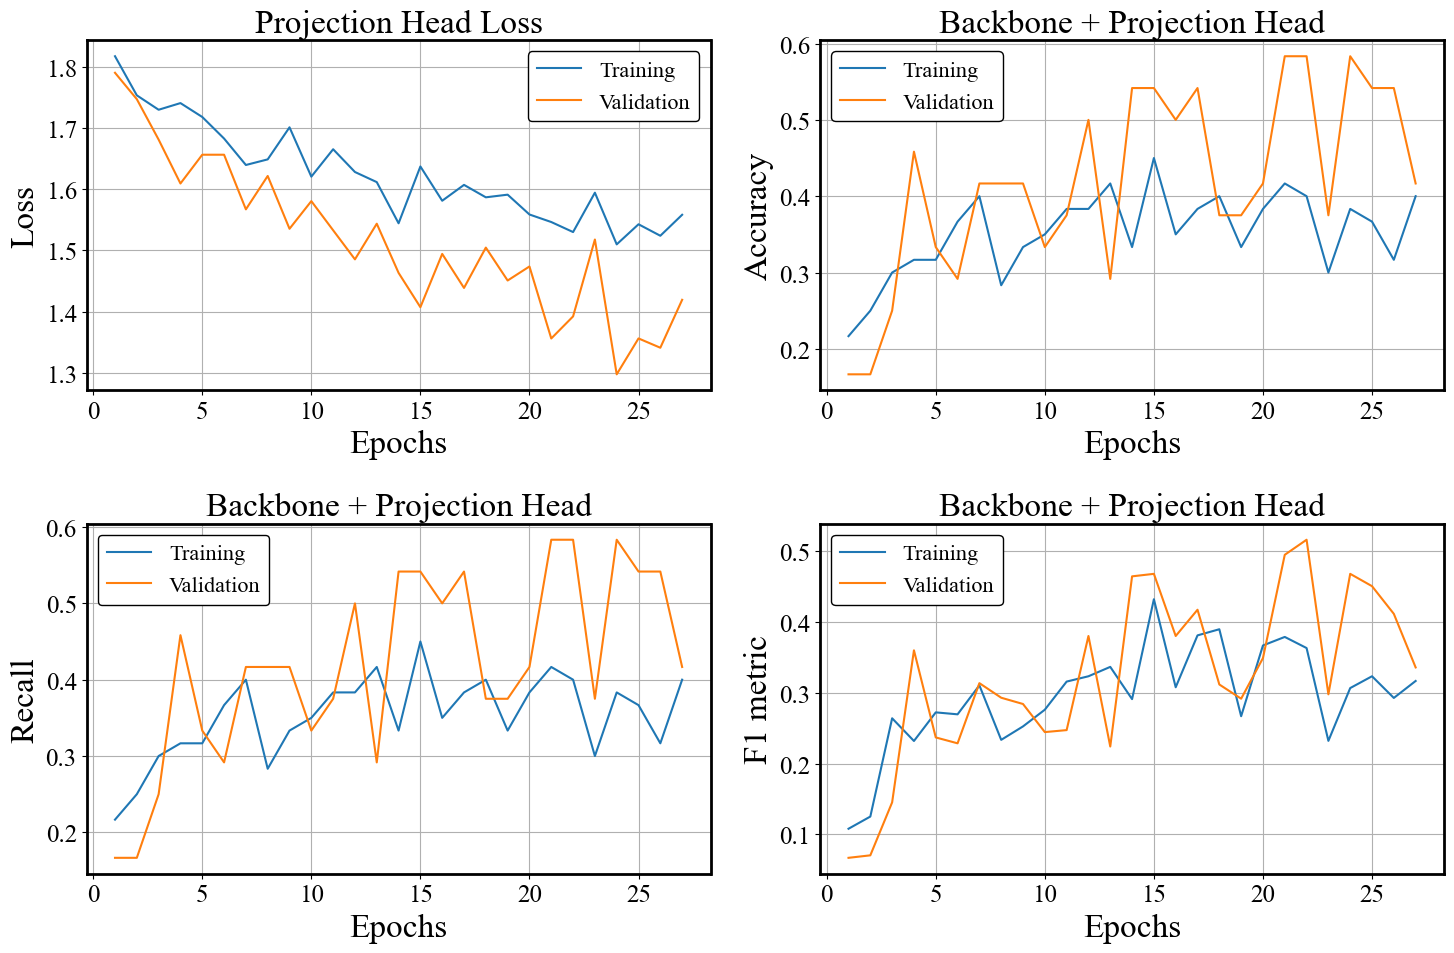

In [14]:
plot_head_metrics(downstream_model_frozen)

In [15]:
# Configuring the Test Dataloader
test_dataloader = downstream_datamodule.test_dataloader()

# Visualizing the embedding using t-SNE
time_latents, freq_latents, y_true, y_pred = extract_latent_representations(downstream_model_frozen, test_dataloader,device=device)

In [16]:
label_mapping = {
    0: 'Walking',
    1: 'Walk upstairs',
    2: 'Walk downstairs',
    3: 'Sitting',
    4: 'Standing',
    5: 'Laying'
}

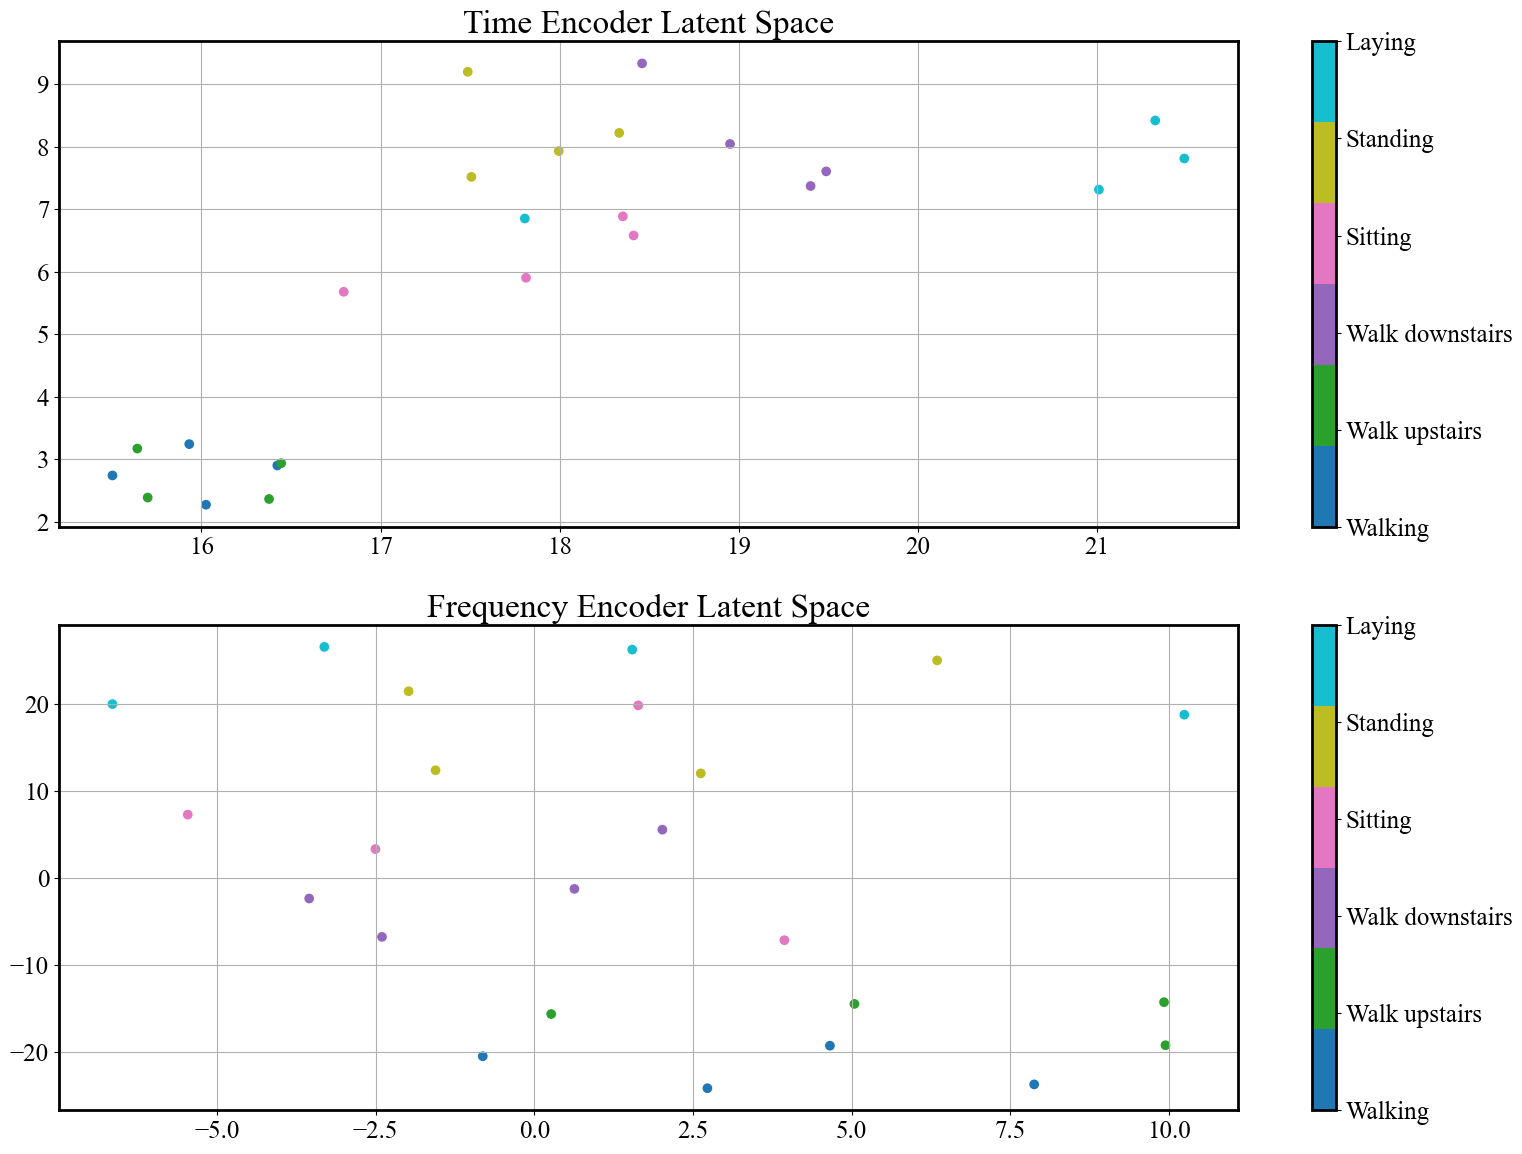

In [17]:
visualize_tsne(time_latents, freq_latents, y_true, label_mapping=label_mapping, perplexity=10)

In [18]:
print(classification_report(y_true, y_pred, target_names=[label_mapping[i] for i in range(len(label_mapping))]))

                 precision    recall  f1-score   support

        Walking       0.33      1.00      0.50         4
  Walk upstairs       0.00      0.00      0.00         4
Walk downstairs       0.50      0.25      0.33         4
        Sitting       0.33      0.50      0.40         4
       Standing       0.50      0.25      0.33         4
         Laying       0.50      0.25      0.33         4

       accuracy                           0.38        24
      macro avg       0.36      0.38      0.32        24
   weighted avg       0.36      0.38      0.32        24



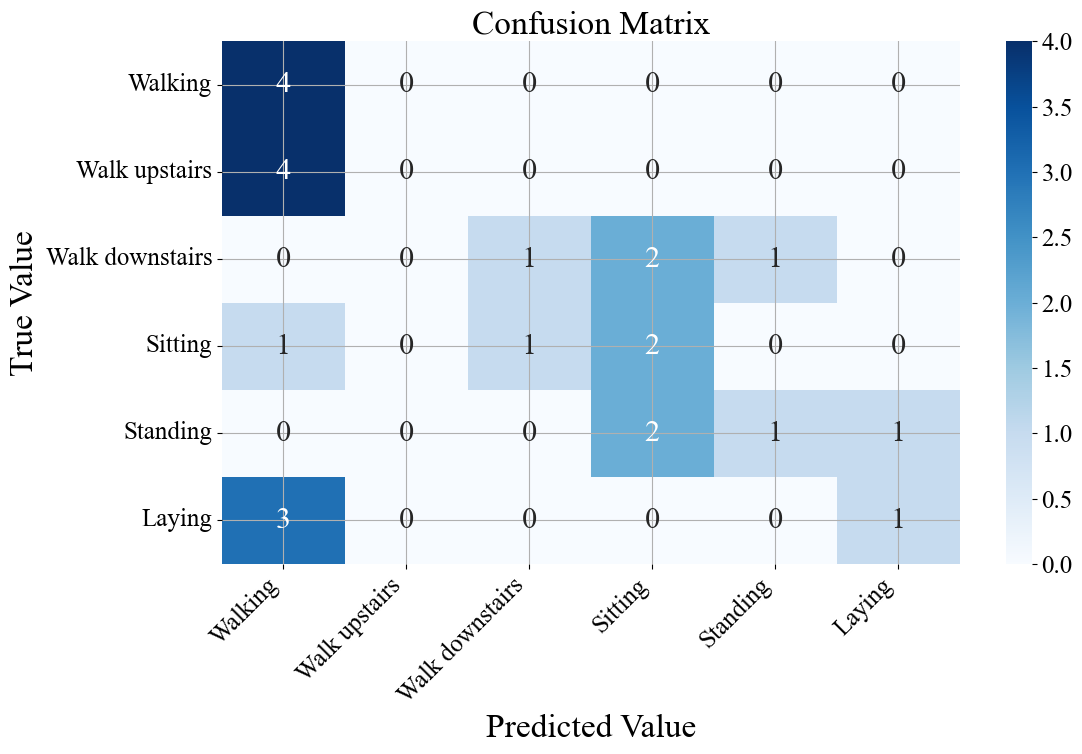

In [19]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred, label_mapping=label_mapping)

## 5.2 Unfrozen Backbone for Fine Tuning

In [20]:
downstream_model_unfrozen = build_downstream_model(backbone=backbone, 
                                          prediction_head=None, # Use the default head
                                          global_config_file=global_config_file)




downstream_lightning_trainer_unfrozen, experiment_path = build_lightning_trainer(log_dir=log_dir, 
                                                       experiment_name=experiment_name, 
                                                       verbose=True,
                                                       version='Downstream_Unfrozen',
                                                       max_epochs=300, 
                                                       min_delta=0.001,
                                                       patience=20,
                                                       monitor='train_loss_total',
                                                       )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
downstream_model_unfrozen.unfreeze_backbone()
downstream_lightning_trainer_unfrozen.fit(downstream_model_unfrozen,downstream_datamodule) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | backbone        | TFC_Backbone       | 118 K 
1 | projection_head | TFC_Projector_Head | 16.8 K
2 | criterion       | CrossEntropyLoss   | 0     
3 | train_accuracy  | MulticlassAccuracy | 0     
4 | val_accuracy    | MulticlassAccuracy | 0     
5 | train_recall    | MulticlassRecall   | 0     
6 | val_recall      | MulticlassRecall   | 0     
7 | train_f1        | MulticlassF1Score  | 0     
8 | val_f1          | MulticlassF1Score  | 0     
-------------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.543     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 30/30 [00:10<00:00,  2.82it/s, val_loss_total=30.40, val_accuracy=0.500, val_f1=0.338, train_loss_total=45.20, train_accuracy=0.233, train_f1=0.158]

Metric train_loss_total improved. New best score: 45.165


Epoch 1: 100%|██████████| 30/30 [00:01<00:00, 15.54it/s, val_loss_total=18.40, val_accuracy=0.375, val_f1=0.328, train_loss_total=12.10, train_accuracy=0.400, train_f1=0.304]

Metric train_loss_total improved by 33.036 >= min_delta = 0.001. New best score: 12.129


Epoch 4: 100%|██████████| 30/30 [00:01<00:00, 16.41it/s, val_loss_total=41.40, val_accuracy=0.333, val_f1=0.173, train_loss_total=9.510, train_accuracy=0.467, train_f1=0.438]

Metric train_loss_total improved by 2.624 >= min_delta = 0.001. New best score: 9.505


Epoch 6: 100%|██████████| 30/30 [00:01<00:00, 16.51it/s, val_loss_total=14.20, val_accuracy=0.500, val_f1=0.404, train_loss_total=4.320, train_accuracy=0.350, train_f1=0.234]

Metric train_loss_total improved by 5.190 >= min_delta = 0.001. New best score: 4.315


Epoch 7: 100%|██████████| 30/30 [00:01<00:00, 15.39it/s, val_loss_total=7.560, val_accuracy=0.583, val_f1=0.478, train_loss_total=3.120, train_accuracy=0.500, train_f1=0.448]

Metric train_loss_total improved by 1.193 >= min_delta = 0.001. New best score: 3.122


Epoch 12: 100%|██████████| 30/30 [00:01<00:00, 16.71it/s, val_loss_total=9.110, val_accuracy=0.458, val_f1=0.357, train_loss_total=2.950, train_accuracy=0.567, train_f1=0.567]

Metric train_loss_total improved by 0.171 >= min_delta = 0.001. New best score: 2.951


Epoch 14: 100%|██████████| 30/30 [00:01<00:00, 15.18it/s, val_loss_total=14.10, val_accuracy=0.458, val_f1=0.367, train_loss_total=2.280, train_accuracy=0.533, train_f1=0.497]

Metric train_loss_total improved by 0.672 >= min_delta = 0.001. New best score: 2.279


Epoch 20: 100%|██████████| 30/30 [00:01<00:00, 16.37it/s, val_loss_total=6.870, val_accuracy=0.500, val_f1=0.418, train_loss_total=1.400, train_accuracy=0.617, train_f1=0.606]

Metric train_loss_total improved by 0.881 >= min_delta = 0.001. New best score: 1.398


Epoch 29: 100%|██████████| 30/30 [00:01<00:00, 15.52it/s, val_loss_total=4.410, val_accuracy=0.375, val_f1=0.325, train_loss_total=1.370, train_accuracy=0.600, train_f1=0.535]

Metric train_loss_total improved by 0.031 >= min_delta = 0.001. New best score: 1.368


Epoch 31: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s, val_loss_total=4.540, val_accuracy=0.375, val_f1=0.304, train_loss_total=1.330, train_accuracy=0.583, train_f1=0.532]

Metric train_loss_total improved by 0.038 >= min_delta = 0.001. New best score: 1.330


Epoch 33: 100%|██████████| 30/30 [00:01<00:00, 16.09it/s, val_loss_total=29.00, val_accuracy=0.375, val_f1=0.321, train_loss_total=1.290, train_accuracy=0.667, train_f1=0.619]

Metric train_loss_total improved by 0.040 >= min_delta = 0.001. New best score: 1.290


Epoch 35: 100%|██████████| 30/30 [00:01<00:00, 17.30it/s, val_loss_total=4.290, val_accuracy=0.375, val_f1=0.341, train_loss_total=1.140, train_accuracy=0.700, train_f1=0.611]

Metric train_loss_total improved by 0.154 >= min_delta = 0.001. New best score: 1.136


Epoch 38: 100%|██████████| 30/30 [00:01<00:00, 17.02it/s, val_loss_total=4.480, val_accuracy=0.375, val_f1=0.319, train_loss_total=0.989, train_accuracy=0.733, train_f1=0.712]

Metric train_loss_total improved by 0.147 >= min_delta = 0.001. New best score: 0.989


Epoch 58: 100%|██████████| 30/30 [00:01<00:00, 17.17it/s, val_loss_total=2.780, val_accuracy=0.375, val_f1=0.312, train_loss_total=1.580, train_accuracy=0.733, train_f1=0.688]

Monitored metric train_loss_total did not improve in the last 20 records. Best score: 0.989. Signaling Trainer to stop.


Epoch 58: 100%|██████████| 30/30 [00:01<00:00, 17.03it/s, val_loss_total=2.780, val_accuracy=0.375, val_f1=0.312, train_loss_total=1.580, train_accuracy=0.733, train_f1=0.688]


In [22]:
downstream_save_weights(downstream_model_frozen,  experiment_path, SSL_technique_prefix)
print(f"Downstream weights saved at: {os.path.join(experiment_path, 'pth_files', f'{SSL_technique_prefix}_downstream_weights.pth')}")

Saving downstream weights at lightning_logs/TF_C/Downstream_Unfrozen\pth_files\TF_C_downstream_weights.pth
Downstream weights saved at: lightning_logs/TF_C/Downstream_Unfrozen\pth_files\TF_C_downstream_weights.pth


### Results

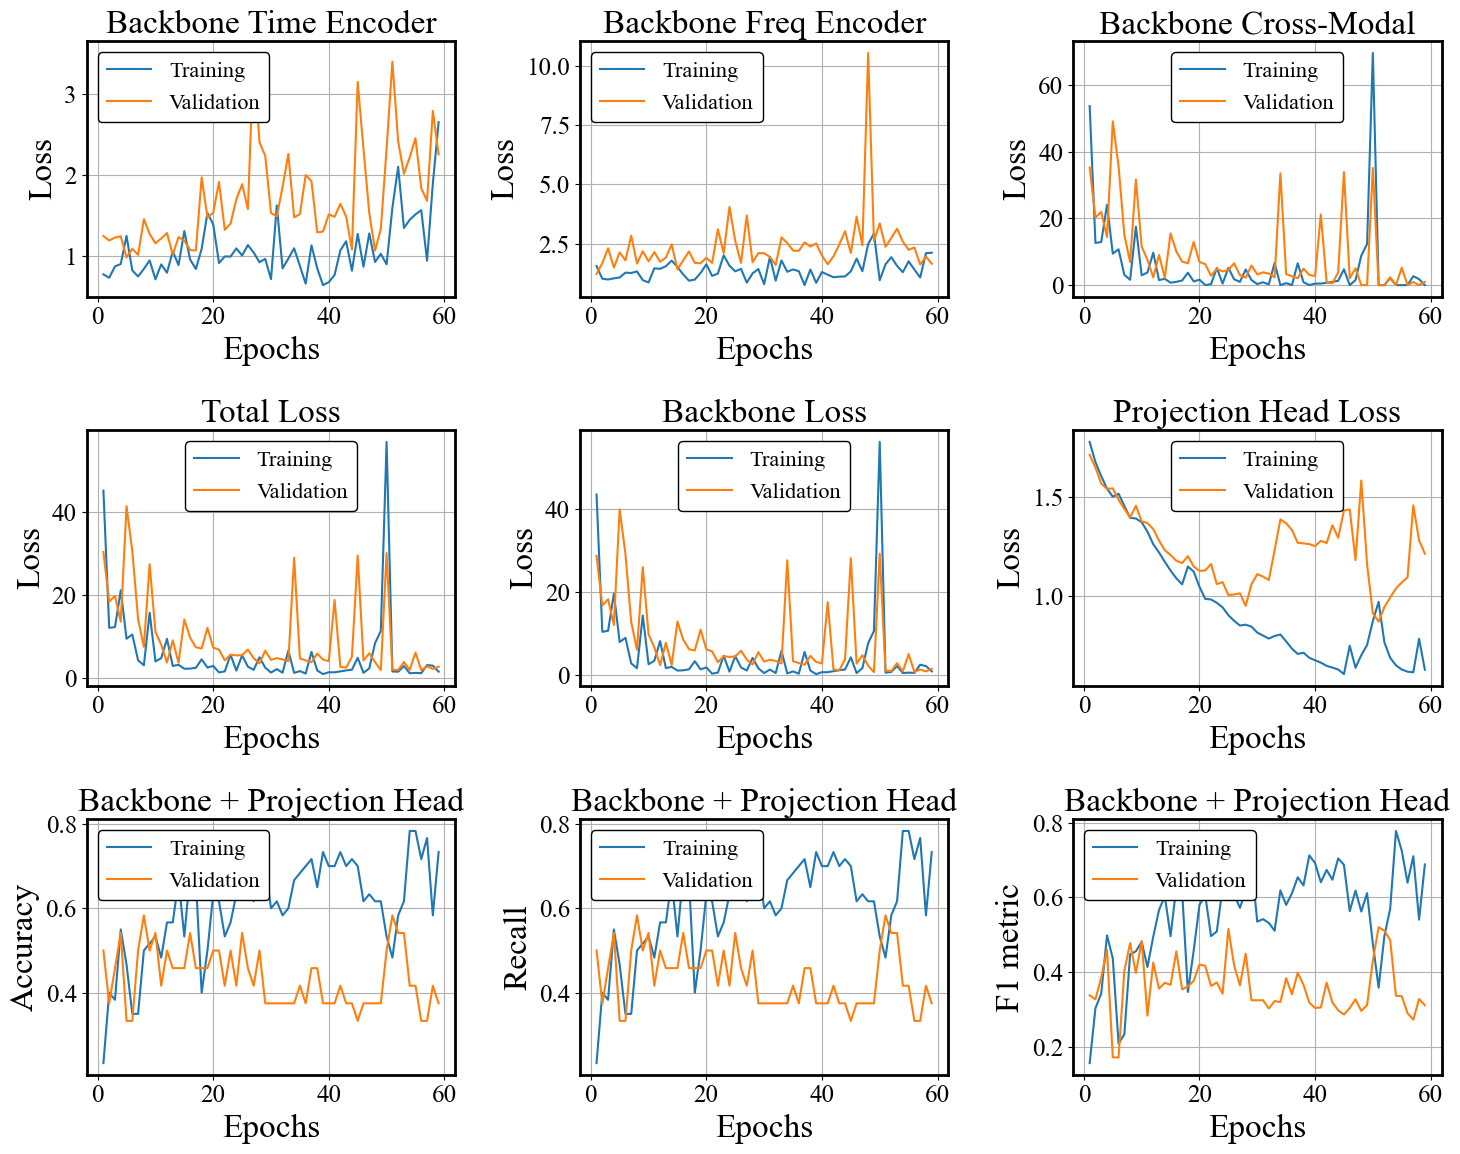

In [28]:
plot_model_metrics(downstream_model_unfrozen)

In [29]:
# Configuring the Test Dataloader
test_dataloader = downstream_datamodule.test_dataloader()

# Visualizing the embedding using t-SNE
time_latents, freq_latents, y_true, y_pred = extract_latent_representations(downstream_model_unfrozen, test_dataloader,device=device)

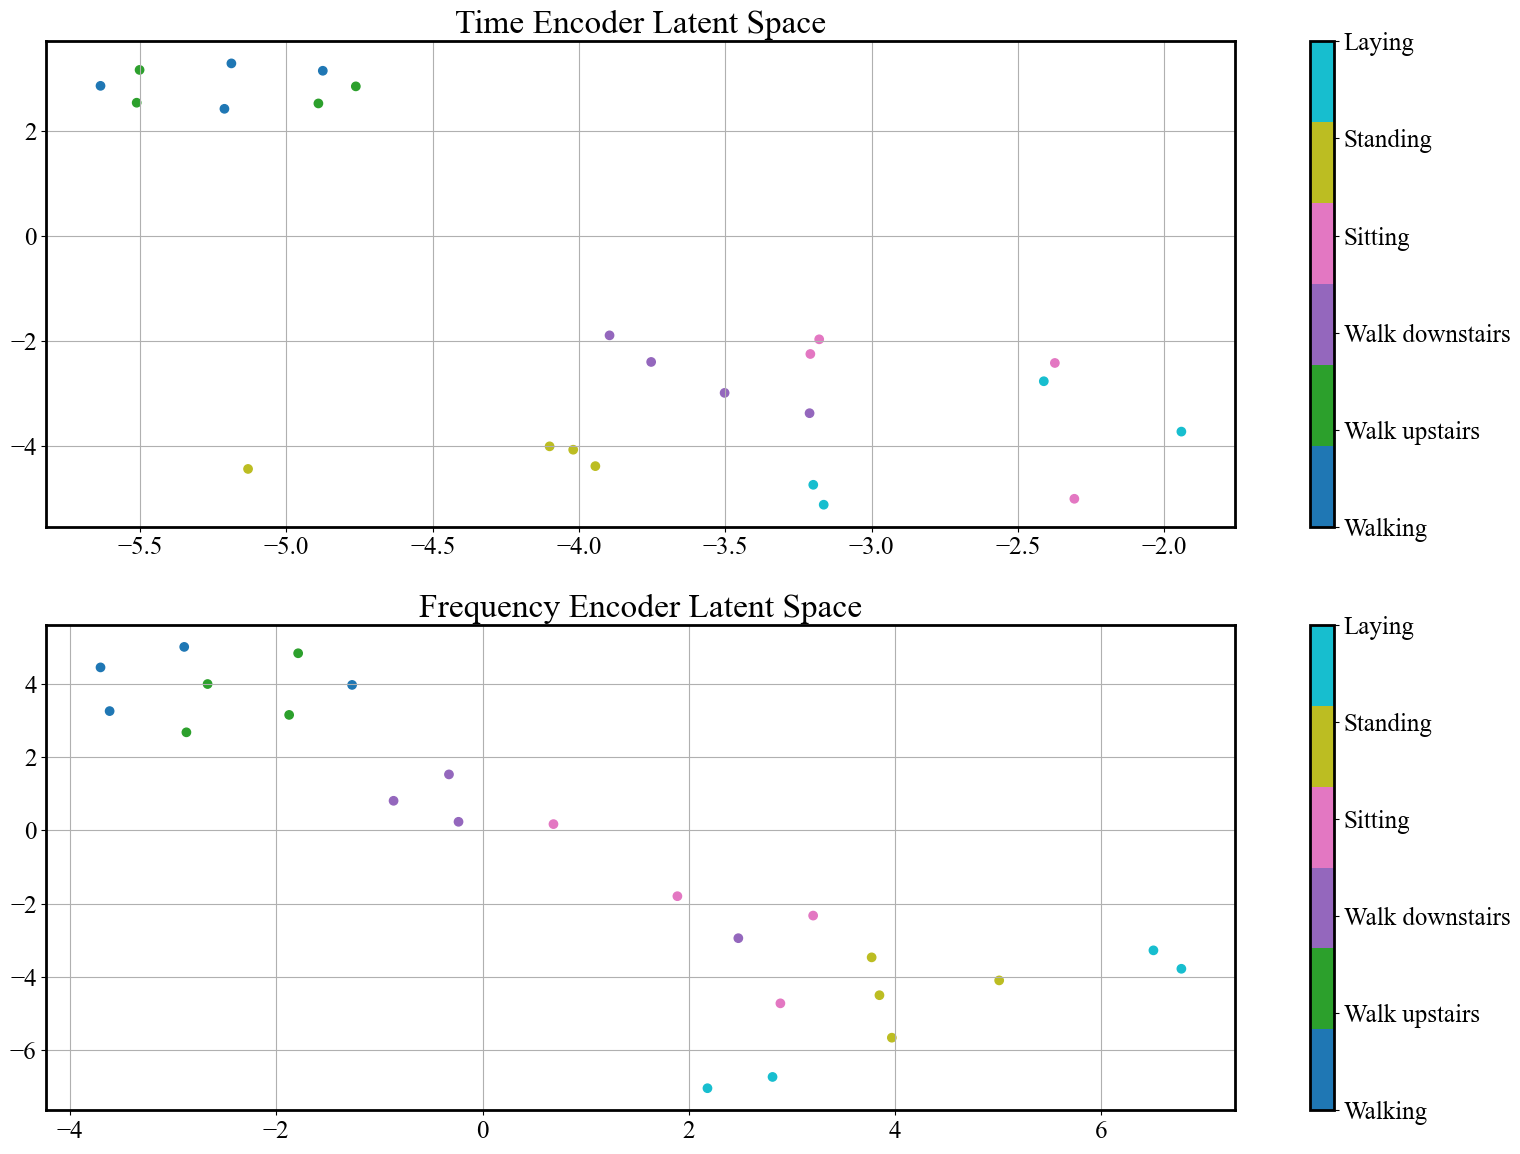

In [30]:
visualize_tsne(time_latents, freq_latents, y_true, label_mapping=label_mapping, perplexity=10)

In [31]:
print(classification_report(y_true, y_pred, target_names=[label_mapping[i] for i in range(len(label_mapping))]))

                 precision    recall  f1-score   support

        Walking       0.50      1.00      0.67         4
  Walk upstairs       0.00      0.00      0.00         4
Walk downstairs       0.60      0.75      0.67         4
        Sitting       1.00      0.25      0.40         4
       Standing       0.67      1.00      0.80         4
         Laying       0.75      0.75      0.75         4

       accuracy                           0.62        24
      macro avg       0.59      0.62      0.55        24
   weighted avg       0.59      0.62      0.55        24



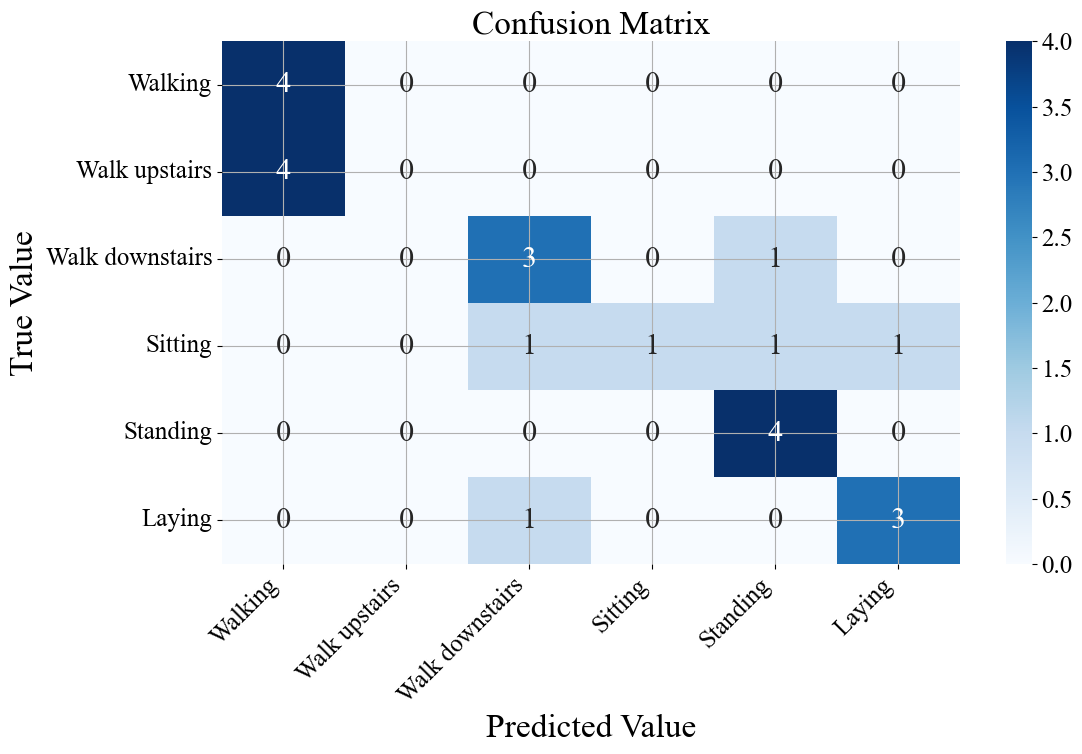

In [32]:
plot_confusion_matrix(y_true=y_true, y_pred=y_pred, label_mapping=label_mapping)